# Sørsdal Glacier Plots

In [ ]:
import rioxarray as rio
import xarray as xr
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib_scalebar.scalebar import ScaleBar
import cartopy as ctp
from obspy.core import UTCDateTime
from obspy.core.inventory import inventory
from cryoquake import data_objects as do
from cryoquake import event_calculation as ec
from scipy.integrate import trapezoid


#import netCDF4 as nc
#import xarray as xr
#import rioxarray as rio
#import rasterio as rs
#import h5py
#import geopandas as gpd
#import fiona
from PIL import Image
Image.MAX_IMAGE_PIXELS = None # Needed to prevent a DecompressionBombError for high-resolution images
#import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import datetime
import pandas as pd

from matplotlib.dates import DateFormatter, DayLocator
from obspy.imaging.util import _set_xaxis_obspy_dates

from matplotlib import rc
import matplotlib.font_manager as fm

optima_path = '/System/Library/Fonts/Optima.ttc'

fm.fontManager.addfont(optima_path)
prop = fm.FontProperties(fname=optima_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
#rc('text', usetex=True)
rc('font', size=8)
#rc('font', **{'family': 'sans-serif', 'sans-serif': ['Optima']})

one_col = 3.35 #inches
two_col = 7.0 #inches

## Fig. 2: Site Map

In [43]:
local_path = '/Users/jmagyar/Documents/SorsdalData'
cloud_path = '/Users/jmagyar/Library/Mobile Documents/com~apple~CloudDocs/Outputs/Icequakes'
c_path = os.path.join(cloud_path,'sorsdal_catalogues')
sat_path = os.path.join(local_path,'satellite')
p_path = os.path.join(cloud_path,'sorsdal_plots')
w_path = os.path.join(local_path,'waveforms')

sat_files = os.listdir(sat_path)

"""ENVIRONMENTAL DATA"""


t1 = UTCDateTime(2018,1,1)
t2 = UTCDateTime(2018,2,15) #for now, just test with a couple of days to check all is working
ref_time = UTCDateTime(2018,1,10) #for finding the response information


env_path = os.path.join(local_path,'environmental')
outplots = os.path.join(cloud_path,'catalogue_plots')
spec_path = os.path.join(local_path,'spectrograms')


chunk = do.SeismicChunk(t1,t2,time_offset=7) #local time is UTC + 07:00

chunk.context('timeseries')
chunk.attach_environmental(env_path)
temp = chunk.env_stream.select(channel='TEM')[0]
tide = chunk.env_stream.select(channel='TID')[0]
phase = chunk.env_stream.select(channel='PHA')[0]

In [44]:
all_bands = rio.open_rasterio(os.path.join(sat_path,'LC08_L1GT_124108_20180125_20180206_RGB.vrt'),mask=True)
blue = rio.open_rasterio(os.path.join(sat_path,'LC08_L1GT_124108_20180125_20180206_01_T2_B2.TIF'),mask=True)
green = rio.open_rasterio(os.path.join(sat_path,'LC08_L1GT_124108_20180125_20180206_01_T2_B3.TIF'),mask=True)
red = rio.open_rasterio(os.path.join(sat_path,'LC08_L1GT_124108_20180125_20180206_01_T2_B4.TIF'),mask=True)

blue['band'] = np.array([3])
green['band'] = np.array([2])
red['band'] = np.array([1])

In [45]:
rgb = []
for band in [red,green,blue]:
    band = band.where(band > 0)
    min_val = band.quantile(0.02)
    max_val = band.quantile(0.98)

    band = ((band - min_val) / (max_val - min_val)).clip(0, 1)
    rgb.append(band)

rgb = xr.concat(rgb,dim='band')

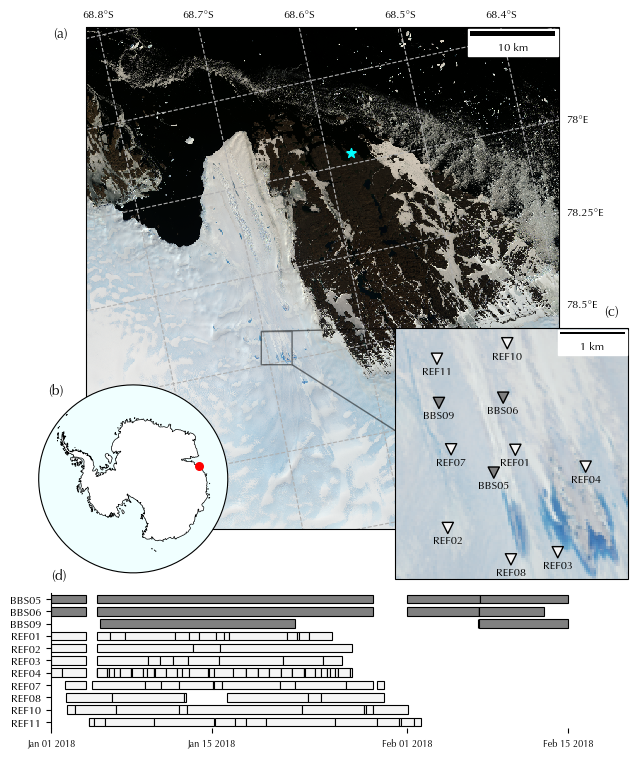

In [46]:
# Set base figure & gridspec

fig = plt.figure(figsize = (two_col, 1.3*two_col), facecolor = "w")
gs = fig.add_gridspec(nrows=2,height_ratios=[1,0.27])

# Define the projections we need to use (see below for explanation)
map_proj = ccrs.SouthPolarStereo()
wgs84 = ccrs.PlateCarree(globe=ccrs.Globe(datum='WGS84', ellipse='WGS84'))
epsg3031 = ccrs.epsg(3031)
epsg3412 = ccrs.epsg(3412)

# ----------------------------------------------------------------------------------- #
# --- Left subplot: plotting BedMachine bed topography (with MEaSUREs boundaries) --- #
# ----------------------------------------------------------------------------------- #
ax = fig.add_subplot(gs[0],projection = map_proj)
ax.set_extent([77.7, 78.9, -68.83, -68.43], crs = wgs84) # Define map extent in axis via [minlon, maxlon, minlat, maxlat]


rgb.plot.imshow(ax = ax, transform = ccrs.epsg(3031),add_colorbar=False,add_labels=False) # Sea-ice data set as NSIDC Sea Ice Polar Stereographic South (EPSG:3412)
#ax.gridlines(draw_labels = True, linestyle = '--')

#ax.add_geometries(groundingline_data.geometries(), ccrs.epsg(3031), facecolor = 'none', edgecolor = 'yellow', linewidth = 1.2)
gl = ax.gridlines(crs=wgs84, draw_labels = {'top':'y','right':'x'}, linestyle = '--',x_inline=False,y_inline=False,rotate_labels=False)


scalebar = ScaleBar(1, "m", length_fraction=0.25)
ax.add_artist(scalebar)

ax.annotate('(a)',(-0.07,0.98),xycoords='axes fraction',fontsize=10)


stat_path = os.path.join(local_path,'stations/sorsdal_stations.xml')

inv = inventory.read_inventory(stat_path,level='response').select(channel='??Z')

network_lst = []
station_lst = []
lat_lst = []
lon_lst = []
for network in inv:
    for station in network:
        network_lst.append(network.code)
        station_lst.append(station.code)
        lat_lst.append(station.latitude)
        lon_lst.append(station.longitude)

station_df = pd.DataFrame({'Network':network_lst,'Station':station_lst,'Latitude':lat_lst,'Longitude':lon_lst})
#station_df.plot.scatter(ax = ax, x = 'Longitude', y = 'Latitude', transform = wgs84, c = 'red', marker = '^', s = 30)


davis_lat = -68.575938
davis_lon = 77.969516

ax.scatter(davis_lon,davis_lat,s=50,marker='*',color='cyan',transform=wgs84)


inset_ax = ax.inset_axes(bounds = [0.65, -0.1, 0.5, 0.5], transform = ax.transAxes, projection = map_proj)
inset_ax.set_extent([78.42, 78.50, -68.703, -68.677], crs = wgs84)
ax.indicate_inset_zoom(inset_ax, edgecolor = 'black') # indicate on main axes the inset axes

rgb.plot.imshow(ax = inset_ax, transform = ccrs.epsg(3031),add_colorbar=False,add_labels=False) # Sea-ice data set as NSIDC Sea Ice Polar Stereographic South (EPSG:3412)


#station_df.plot.scatter(ax = inset_ax, x = 'Longitude', y = 'Latitude', transform = wgs84, c = 3*['rosybrown'] + 8*['lightsteelblue'], edgecolors=7*['black'],marker = 'v', s = 60)
station_df.plot.scatter(ax = inset_ax, x = 'Longitude', y = 'Latitude', transform = wgs84, c = 3*['grey'] + 8*['whitesmoke'], edgecolors=7*['black'],marker = 'v', s = 65)

for i, row in station_df.iterrows():
    station_ll = map_proj.transform_point(row['Longitude'],row['Latitude'],wgs84)
    inset_ax.annotate(row['Station'],station_ll,c='black',weight='bold',fontsize=8,ha='center',va='top',xytext=(0, -0.7), textcoords='offset fontsize')

inset_ax.annotate('(c)',(0.9,1.05),xycoords='axes fraction',fontsize=10)

scalebar = ScaleBar(1, "m", length_fraction=0.35)
inset_ax.add_artist(scalebar)

ant_ax = ax.inset_axes(bounds = [-0.1, -0.1, 0.4, 0.4], transform = ax.transAxes, projection = map_proj)
ant_ax.set_extent([0,360,-90,-60],crs=wgs84)
ant_ax.coastlines(lw=0.5)
ant_ax.add_feature(ctp.feature.OCEAN,facecolor='azure')
#ant_ax.add_geometries(coastline_data.geometries(), ccrs.epsg(3031), facecolor='white', edgecolor = 'black',lw=0.3)

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)
ant_ax.set_boundary(circle, transform = ant_ax.transAxes)

ant_ax.scatter(davis_lon,davis_lat,s=30,marker='o',color='red',transform=wgs84,zorder=5)

ant_ax.annotate('(b)',(0.05,0.95),xycoords='axes fraction',fontsize=10)


avail = pd.read_csv('stream_availability.csv')

avail_ax = fig.add_subplot(gs[1])

i = 0
labels = []
coords = []
#stations = {'REF01':1,'REF02':2,'REF03':3,'REF04':4,'BBS05':5,'BBS06':6,'REF07':7,'REF08':8,'BBS09':9,'REF10':10,'REF11':11}
stations = ['BBS05','BBS06','BBS09','REF01','REF02','REF03','REF04','REF07','REF08','REF10','REF11']

rows = []

for code in stations:
    if code[0] == 'B':
        channel = 'HHZ'
    else:
        channel = 'GLZ'

    subset = avail[(avail['Station']==code) & (avail['Channel']==channel)]
    
    starts = subset['Start'].to_numpy()
    ends = subset['End'].to_numpy()

    short_start = []
    short_end = []
    short_start.append(starts[0])

    for i, start in enumerate(starts[1:]):
        if start != ends[i]:
            short_start.append(start)
            short_end.append(ends[i])

    short_end.append(ends[-1])

    for i in range(len(short_start)):
        rows.append({'Station':code,'Start':short_start[i],'End':short_end[i]})

df = pd.DataFrame(data=rows)

for i, code in enumerate(stations):
    subset = df[(df['Station']==code)]
    start = pd.to_datetime(subset['Start'])# + pd.Timedelta(hours=chunk.time_offset)
    end = pd.to_datetime(subset['End']) #+ pd.Timedelta(hours=chunk.time_offset)
    duration = end - start
    
    if code[0] == 'B':
        color = 'grey'
    else:
        color='whitesmoke'
        
    avail_ax.barh(-i,duration,height=0.7,left=start,facecolor=color,edgecolor='black',lw=0.8)
    coords.append(-i)
    labels.append(code)

avail_ax.set_yticks(coords)
avail_ax.set_yticklabels(labels)
avail_ax.spines['right'].set_visible(False)
#avail_ax.spines['left'].set_visible(False)
avail_ax.spines['top'].set_visible(False)
avail_ax.spines['bottom'].set_visible(False)

#myFmt = DateFormatter("%b %d %y")
#avail_ax.xaxis.set_major_formatter(myFmt)
#avail_ax.xaxis.set_major_locator(DayLocator(interval=15))
_set_xaxis_obspy_dates(avail_ax)
avail_ax.set_ylim(-10.5,0.5)

avail_ax.annotate('(d)',(0,1.1),xycoords='axes fraction',fontsize=10)

fig.savefig(os.path.join(p_path,'Fig2_Sorsdal_Network.pdf'),bbox_inches='tight',dpi=400)

## Fig. 3: Catalogue Summary

/Users/jmagyar/Library/Mobile Documents/com~apple~CloudDocs/Code/Icequakes_remote/iqvis/data_objects.py:663: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  event_cat = pd.concat(events,ignore_index=True)
/Users/jmagyar/Library/Mobile Documents/com~apple~CloudDocs/Code/Icequakes_remote/iqvis/data_objects.py:674: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trace_cat = pd.concat(traces,ignore_index=True)
/var/folders/z4/gw28hj796zjdxt4nltp_h5g1m6cl00/T/ipykernel_34354/3774860066.py:35: RuntimeWarn

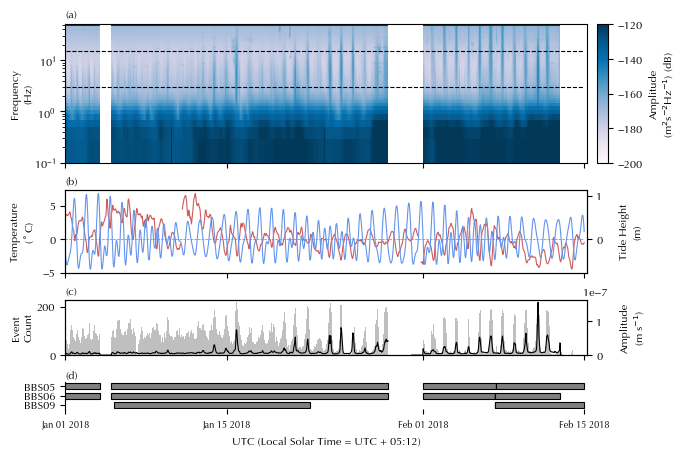

In [47]:
avail = pd.read_csv('stream_availability.csv')
event_cat = do.EventCatalogue(t1,t2,c_path) #get the event catalogue


code = '2A.BBS06..HHZ'

full = np.load(os.path.join(spec_path,'full_spectrogram__' + code + '__' + chunk.str_name + '.npz'),allow_pickle=True)
daily = np.load(os.path.join(spec_path,'diurnal_spectrogram__' + code + '__' + chunk.str_name + '.npz'),allow_pickle=True)
tidal = np.load(os.path.join(spec_path,'tide_phase_spectrogram__' + code + '__' + chunk.str_name + '.npz'),allow_pickle=True)

resp = inv.get_response(code,ref_time)
sens = abs(resp.get_evalresp_response_for_frequencies(full['f']))

"""
Full chunk plotting
"""

f_band = full['f'][(full['f']>3)&(full['f']<15)]
spec_band = full['spec'][(full['f']>3)&(full['f']<15),:]
spec_band /= sens[(full['f']>3)&(full['f']<15),None] **2
med_amp = np.sqrt(trapezoid(spec_band,f_band,axis=0))

fig = plt.figure(figsize=(two_col,two_col/1.4))
grid_spec = fig.add_gridspec(nrows=4,ncols=2,width_ratios=[1,0.02],height_ratios=[1,0.6,0.4,0.2],wspace=0.04,hspace=0.35)

start_mt = chunk.starttime.matplotlib_date
end_mt = chunk.endtime.matplotlib_date

#firstly deal with the spectrogram + colourbar in the top row.
spec_ax = fig.add_subplot(grid_spec[0,0])
spec_cb_ax = fig.add_subplot(grid_spec[0,1])

t_mt = [time.matplotlib_date for time in full['t']]

db_spec = 10 * np.log10(full['spec'][1:,:]) - 20 * np.log10(sens)[1:,None]

spec_plot = spec_ax.pcolormesh(t_mt,full['f'][1:],db_spec,cmap='PuBu',vmax=-120,vmin=-200,rasterized=True)
spec_ax.hlines([3,15],xmin=t_mt[0],xmax=t_mt[-1],color='black',ls='--',lw=0.8)
cb = plt.colorbar(spec_plot,cax=spec_cb_ax,label='Amplitude\n' +  r'(m$^2$s$^{-2}$Hz$^{-1}$) (dB)')

spec_ax.set_yscale('log')
spec_ax.set_ylabel('Frequency\n(Hz)',labelpad=0)

#environmental data and band-integrated median seismic amplitude
time_series_ax = fig.add_subplot(grid_spec[1,0],sharex=spec_ax)

tide_ax = plt.twinx(time_series_ax)
time_series_ax.hlines(0,xmin=start_mt,xmax=end_mt,color='grey',ls='--',lw=0.5)

tide_ax.plot(t_mt,full['tide'],c='cornflowerblue',lw=0.8)
tide_ax.set_ylabel('Tide Height\n(m)',labelpad=12)

time_series_ax.plot(t_mt,full['temp'],c='indianred',lw=0.8)
time_series_ax.set_ylabel('Temperature\n' + r'($^\circ$C)',labelpad=5)

#histogram of event detections
hist_ax = fig.add_subplot(grid_spec[2,0],sharex=spec_ax)


hist_ax.bar(t_mt,height=full['events'],width=t_mt[1]-t_mt[0],bottom=0,align='center',color='grey',alpha=0.5)
hist_ax.set_ylabel('Event\nCount',labelpad=2)

amp_ax = plt.twinx(hist_ax)
amp_ax.plot(t_mt,med_amp,color='black',lw=0.8)
amp_ax.set_ylim(bottom=0)


amp_ax.set_ylabel('Amplitude\n' + r'(m s$^{-1}$)',labelpad=12)
amp_ax.yaxis.get_offset_text().set_position((1.04,1))

#data availability for the broadband stations
avail_ax = fig.add_subplot(grid_spec[3,0],sharex=spec_ax)


i = 0
labels = []
coords = []
for net in inv.select(station='BBS??',channel='??Z'):
    for sta in net:
        for ch in sta:
            subset = df[(df['Station']==sta.code)]
            start = np.array([UTCDateTime(time).matplotlib_date for time in subset['Start']])#pd.to_datetime(subset['Start'])# + pd.Timedelta(hours=chunk.time_offset)
            end = np.array([UTCDateTime(time).matplotlib_date for time in subset['End']])#pd.to_datetime(subset['End']) #+ pd.Timedelta(hours=chunk.time_offset)
            duration = end - start

            avail_ax.barh(i,duration,height=0.65,left=start,facecolor='grey',edgecolor='black',lw=0.8)
            coords.append(i)
            labels.append(sta.code)

            i -= 1


avail_ax.set_yticks(coords)
avail_ax.set_yticklabels(labels)
avail_ax.spines['right'].set_visible(False)
#avail_ax.spines['left'].set_visible(False)
avail_ax.spines['top'].set_visible(False)
avail_ax.spines['bottom'].set_visible(False)

avail_ax.set_ylim(-2.5,0.5)

avail_ax.set_xlim((start_mt,end_mt+0.2))
_set_xaxis_obspy_dates(avail_ax)
plt.setp(spec_ax.get_xticklabels(), visible=False)
plt.setp(time_series_ax.get_xticklabels(), visible=False)
plt.setp(hist_ax.get_xticklabels(), visible=False)

sign = '%+i' % chunk.time_offset
sign = sign[0]
#label = "UTC (Local Time = UTC %s %02i:%02i)" % (sign, abs(chunk.time_offset),(chunk.time_offset % 1 * 60))
label = "UTC (Local Solar Time = UTC + 05:12)" #% (sign, abs(chunk.time_offset),(chunk.time_offset % 1 * 60))

avail_ax.set_xlabel(label)

spec_ax.annotate('(a)',(0,1.05),xycoords='axes fraction')
time_series_ax.annotate('(b)',(0,1.07),xycoords='axes fraction')
hist_ax.annotate('(c)',(0,1.1),xycoords='axes fraction')
avail_ax.annotate('(d)',(0,1.14),xycoords='axes fraction')


fig.savefig(os.path.join(p_path,'Fig3_full_spectrogram.pdf'),dpi=400,bbox_inches='tight')

## Fig. 4: Wrapped Catalogue

/var/folders/z4/gw28hj796zjdxt4nltp_h5g1m6cl00/T/ipykernel_34354/3354513824.py:18: RuntimeWarning: divide by zero encountered in log10
  db_spec = 10 * np.log10(daily['spec'][1:,:]) - 20 * np.log10(sens)[1:,None]
/var/folders/z4/gw28hj796zjdxt4nltp_h5g1m6cl00/T/ipykernel_34354/3354513824.py:71: RuntimeWarning: divide by zero encountered in log10
  db_spec = 10 * np.log10(tidal['spec'][1:,:]) - 20 * np.log10(sens)[1:,None]


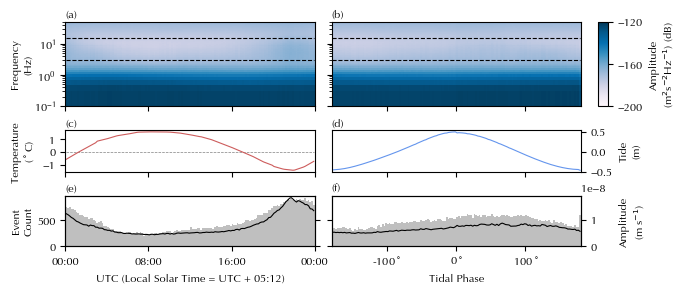

In [48]:
f_band = daily['f'][(daily['f']>3)&(daily['f']<15)]
spec_band = daily['spec'][(daily['f']>3)&(daily['f']<15),:]
spec_band /= sens[(daily['f']>3)&(daily['f']<15),None]**2
med_amp = np.sqrt(trapezoid(spec_band,f_band,axis=0))

fig = plt.figure(figsize=(two_col,two_col/2.4))
grid_spec = fig.add_gridspec(nrows=3,ncols=3,width_ratios=[0.5,0.5,0.02],height_ratios=[1,0.5,0.6],wspace=0.1,hspace=0.4)

#firstly deal with the spectrogram + colourbar in the top row.
day_spec_ax = fig.add_subplot(grid_spec[0,0])
#day_spec_ax.set_title('Diurnal Wrapping')
tide_spec_ax = fig.add_subplot(grid_spec[0,1],sharey=day_spec_ax)
#tide_spec_ax.set_title('Tidal Wrapping')
spec_cb_ax = fig.add_subplot(grid_spec[0,2])

t_mt = [time.matplotlib_date for time in daily['t']]

db_spec = 10 * np.log10(daily['spec'][1:,:]) - 20 * np.log10(sens)[1:,None]

spec_plot = day_spec_ax.pcolormesh(t_mt,daily['f'][1:],db_spec,cmap='PuBu',vmin=-200,vmax=-120,rasterized=True)
day_spec_ax.hlines([3,15],xmin=t_mt[0],xmax=t_mt[-1],color='black',ls='--',lw=0.8)
cb = plt.colorbar(spec_plot,cax=spec_cb_ax,label='Amplitude\n' +  r'(m$^2$s$^{-2}$Hz$^{-1}$) (dB)',ticks=[-200,-160,-120])

day_spec_ax.set_yscale('log')
day_spec_ax.set_ylabel('Frequency\n(Hz)',labelpad=0)

#environmental data and band-integrated median seismic amplitude
temp_ax = fig.add_subplot(grid_spec[1,0],sharex=day_spec_ax)


temp_ax.hlines(0,xmin=t_mt[0],xmax=t_mt[-1],color='grey',ls='--',lw=0.5)

temp_ax.plot(t_mt,daily['temp'],c='indianred',lw=0.8)
temp_ax.set_ylabel('Temperature \n' +  r'($^\circ$C)',labelpad=4.5)


#histogram of event detections
day_hist_ax = fig.add_subplot(grid_spec[2,0],sharex=day_spec_ax)

day_hist_ax.bar(t_mt,height=daily['events'],width=t_mt[1]-t_mt[0],bottom=0,align='center',color='grey',alpha=0.5)
day_hist_ax.set_ylabel('Event\nCount',labelpad=2)

day_amp_ax = plt.twinx(day_hist_ax)
day_amp_ax.plot(t_mt,med_amp,color='black',lw=0.8)
day_amp_ax.set_ylim(bottom=0)


plt.setp(day_spec_ax.get_xticklabels(), visible=False)
plt.setp(temp_ax.get_xticklabels(), visible=False)

from matplotlib.dates import DateFormatter, HourLocator

myFmt = DateFormatter("%H:%M")
day_hist_ax.xaxis.set_major_formatter(myFmt)
day_hist_ax.xaxis.set_major_locator(HourLocator(interval=8))


sign = '%+i' % chunk.time_offset
sign = sign[0]
#label = "UTC (Local Time = UTC %s %02i:%02i)" % (sign, abs(chunk.time_offset),(chunk.time_offset % 1 * 60))
label = "UTC (Local Solar Time = UTC + 05:12)"
day_hist_ax.set_xlabel(label)


f_band = tidal['f'][(tidal['f']>3)&(tidal['f']<15)]
spec_band = tidal['spec'][(tidal['f']>3)&(tidal['f']<15),:]
spec_band /= sens[(tidal['f']>3)&(tidal['f']<15),None]**2
med_amp = np.sqrt(trapezoid(spec_band,f_band,axis=0))


db_spec = 10 * np.log10(tidal['spec'][1:,:]) - 20 * np.log10(sens)[1:,None]

spec_plot = tide_spec_ax.pcolormesh(tidal['phase'],tidal['f'][1:],db_spec,cmap='PuBu',vmin=-200,vmax=-120,rasterized=True)
tide_spec_ax.hlines([3,15],xmin=tidal['phase'][0],xmax=tidal['phase'][-1],color='black',ls='--',lw=0.8)

spec_ax.set_yscale('log')

#environmental data and band-integrated median seismic amplitude
tide_ax = fig.add_subplot(grid_spec[1,1],sharex=tide_spec_ax)

tide_ax.plot(tidal['phase'],tidal['tide'],c='cornflowerblue',lw=0.8)
tide_ax.set_ylabel('Tide\n(m)')
tide_ax.yaxis.tick_right()
tide_ax.yaxis.set_label_position('right')


#histogram of event detections
tide_hist_ax = fig.add_subplot(grid_spec[2,1],sharex=tide_spec_ax,sharey=day_hist_ax)
tide_hist_ax.bar(tidal['phase'],height=tidal['events'],width=tidal['phase'][1]-tidal['phase'][0],bottom=0,align='center',color='grey',alpha=0.5)
tide_hist_ax.set_xlabel('Tidal Phase')
tide_hist_ax.set_xticks([-100,0,100],[r'-100$^\circ$',r'0$^\circ$',r'100$^\circ$'])

tide_amp_ax = plt.twinx(tide_hist_ax)
tide_amp_ax.plot(tidal['phase'],med_amp,color='black',lw=0.8)
tide_amp_ax.set_ylabel('Amplitude\n' + r'(m s$^{-1}$)',labelpad=16)
tide_amp_ax.set_ylim(bottom=0)
tide_amp_ax.yaxis.get_offset_text().set_position((1.1,1))
plt.setp(day_amp_ax.get_yaxis().get_offset_text(), visible=False)

tide_amp_ax.sharey(day_amp_ax)


plt.setp(tide_spec_ax.get_xticklabels(), visible=False)
plt.setp(tide_ax.get_xticklabels(), visible=False)
plt.setp(tide_hist_ax.get_yticklabels(), visible=False)
plt.setp(day_amp_ax.get_yticklabels(),visible=False)
plt.setp(tide_spec_ax.get_yticklabels(),visible=False)

day_spec_ax.annotate('(a)',(0,1.05),xycoords='axes fraction')
tide_spec_ax.annotate('(b)',(0,1.05),xycoords='axes fraction')
temp_ax.annotate('(c)',(0,1.1),xycoords='axes fraction')
tide_ax.annotate('(d)',(0,1.1),xycoords='axes fraction')
day_hist_ax.annotate('(e)',(0,1.1),xycoords='axes fraction')
tide_hist_ax.annotate('(f)',(0,1.1),xycoords='axes fraction')

fig.savefig(os.path.join(p_path,'Fig4_wrapped_spectra.pdf'),dpi=400,bbox_inches='tight')

## Fig. 5: Backazimuth Estimates

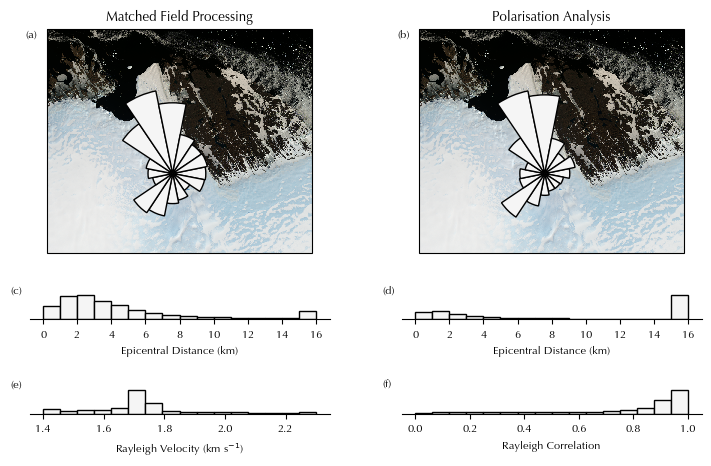

In [49]:
mfp = chunk.load_csv(c_path,'mfp_opt')
mfp.dropna(inplace=True)
pol = chunk.load_csv(c_path,'polarisation_localisation_opt')
pol.dropna(inplace=True)

num_bins = 16

baz_edges = np.linspace(0,2*np.pi,num_bins+1)
rad_edges = np.linspace(0,16,num_bins+1)
corr_edges = np.linspace(0,1,num_bins+1)
vel_edges = np.linspace(1.4,2.3,num_bins+1)

N = len(inv.select(station='REF??'))
locations_ll = np.zeros((N,2))

i = 0
for net in inv.select(station='REF??'):
    for sta in net:
        locations_ll[i,:] = np.array([sta.latitude,sta.longitude])
        i += 1

centre = np.mean(locations_ll,axis=0)


fig = plt.figure(figsize=(two_col,two_col*0.65),constrained_layout=True)
#fig = plt.figure(figsize=(one_col,1.4*one_col),constrained_layout=True)
gs = fig.add_gridspec(nrows=3,ncols=2,height_ratios=[9,1,1],hspace=0.15,wspace=0.15)

# Define the projections we need to use (see below for explanation)
map_proj = ccrs.SouthPolarStereo()
wgs84 = ccrs.PlateCarree(globe=ccrs.Globe(datum='WGS84', ellipse='WGS84'))
epsg3031 = ccrs.epsg(3031)
epsg3412 = ccrs.epsg(3412)

# ----------------------------------------------------------------------------------- #
# --- Left subplot: plotting BedMachine bed topography (with MEaSUREs boundaries) --- #
# ----------------------------------------------------------------------------------- #
mfp_sat_ax = fig.add_subplot(gs[0,0],projection = map_proj)
mfp_sat_ax.set_extent([77.8, 78.8, -68.9, -68.43], crs = wgs84) # Define map extent in axis via [minlon, maxlon, minlat, maxlat]


rgb.plot.imshow(ax = mfp_sat_ax, transform = ccrs.epsg(3031),add_colorbar=False,add_labels=False)
#ax.gridlines(draw_labels = True, linestyle = '--')

polar_centre = map_proj.transform_point(centre[1],centre[0],wgs84)

xlim = mfp_sat_ax.get_xlim()
data_width = xlim[1] - xlim[0]
rose_width = data_width / 1.5

mfp_rose_ax = mfp_sat_ax.inset_axes([polar_centre[0]-rose_width/2,polar_centre[1]-rose_width/2,rose_width,rose_width],transform=mfp_sat_ax.transData,projection='polar')
mfp_rose_ax.set_theta_zero_location('N',offset=-centre[1])
mfp_rose_ax.set_theta_direction(-1)
mfp_rose_ax.set_xticks([])
mfp_rose_ax.set_yticks([])
mfp_rose_ax.spines['polar'].set_visible(False)
mfp_rose_ax.patch.set_alpha(0)

mfp_rad_ax = fig.add_subplot(gs[1,0])
mfp_rad_ax.spines['top'].set_visible(False)
mfp_rad_ax.spines['left'].set_visible(False)
mfp_rad_ax.spines['right'].set_visible(False)
mfp_rad_ax.set_xlabel('Epicentral Distance (km)')
mfp_rad_ax.set_yticks([])

vel_ax = fig.add_subplot(gs[2,0])
vel_ax.spines['top'].set_visible(False)
vel_ax.spines['left'].set_visible(False)
vel_ax.spines['right'].set_visible(False)
vel_ax.set_xlabel('Rayleigh Velocity '+  r'(km s$^{-1}$)')
vel_ax.set_yticks([])

baz_hist, _ = np.histogram(mfp['baz_opt'],bins=baz_edges)
rad_hist, _ = np.histogram(mfp['rad_opt'],bins=rad_edges)
vel_hist, _ = np.histogram(mfp['vel_opt'],bins=vel_edges)

facecolor = 'whitesmoke'
edgecolor = 'black'

mfp_rose_ax.bar(baz_edges[:-1],baz_hist,width=np.diff(baz_edges),align='edge',facecolor=facecolor,edgecolor=edgecolor)
mfp_rad_ax.bar(rad_edges[:-1],rad_hist,width=np.diff(rad_edges),align='edge',facecolor=facecolor,edgecolor=edgecolor)
vel_ax.bar(vel_edges[:-1],vel_hist,width=np.diff(vel_edges),align='edge',facecolor=facecolor,edgecolor=edgecolor)

pol_sat_ax = fig.add_subplot(gs[0,1],projection = map_proj)
pol_sat_ax.set_extent([77.8, 78.8, -68.9, -68.43], crs = wgs84) # Define map extent in axis via [minlon, maxlon, minlat, maxlat]


rgb.plot.imshow(ax = pol_sat_ax, transform = ccrs.epsg(3031),add_colorbar=False,add_labels=False) # Sea-ice data set as NSIDC Sea Ice Polar Stereographic South (EPSG:3412)
#ax.gridlines(draw_labels = True, linestyle = '--')


xlim = pol_sat_ax.get_xlim()
data_width = xlim[1] - xlim[0]
rose_width = data_width / 1.5

pol_rose_ax = pol_sat_ax.inset_axes([polar_centre[0]-rose_width/2,polar_centre[1]-rose_width/2,rose_width,rose_width],transform=pol_sat_ax.transData,projection='polar')
pol_rose_ax.set_theta_zero_location('N',offset=-centre[1])
pol_rose_ax.set_theta_direction(-1)
pol_rose_ax.set_xticks([])
pol_rose_ax.set_yticks([])
pol_rose_ax.spines['polar'].set_visible(False)
pol_rose_ax.patch.set_alpha(0)

pol_rad_ax = fig.add_subplot(gs[1,1])
pol_rad_ax.spines['top'].set_visible(False)
pol_rad_ax.spines['left'].set_visible(False)
pol_rad_ax.spines['right'].set_visible(False)
pol_rad_ax.set_xlabel('Epicentral Distance (km)')
pol_rad_ax.set_yticks([])

corr_ax = fig.add_subplot(gs[2,1])
corr_ax.spines['top'].set_visible(False)
corr_ax.spines['left'].set_visible(False)
corr_ax.spines['right'].set_visible(False)
corr_ax.set_xlabel('Rayleigh Correlation')
corr_ax.set_yticks([])

baz_hist, _ = np.histogram(pol['baz_opt'],bins=baz_edges)
rad_hist, _ = np.histogram(pol['rad_opt'],bins=rad_edges)
corr_hist, _ = np.histogram(pol['corr_opt'],bins=corr_edges)


pol_rose_ax.bar(baz_edges[:-1],baz_hist,width=np.diff(baz_edges),align='edge',facecolor=facecolor,edgecolor=edgecolor)
pol_rad_ax.bar(rad_edges[:-1],rad_hist,width=np.diff(rad_edges),align='edge',facecolor=facecolor,edgecolor=edgecolor)
corr_ax.bar(corr_edges[:-1],corr_hist,width=np.diff(corr_edges),align='edge',facecolor=facecolor,edgecolor=edgecolor)

mfp_rose_ax.annotate('(a)',(-0.33,1.27),xycoords='axes fraction')
pol_rose_ax.annotate('(b)',(-0.33,1.27),xycoords='axes fraction')
mfp_rad_ax.annotate('(c)',(-0.065,1.05),xycoords='axes fraction')
pol_rad_ax.annotate('(d)',(-0.065,1.05),xycoords='axes fraction')
vel_ax.annotate('(e)',(-0.065,1.05),xycoords='axes fraction')
corr_ax.annotate('(f)',(-0.065,1.05),xycoords='axes fraction')

mfp_sat_ax.set_title('Matched Field Processing')
pol_sat_ax.set_title('Polarisation Analysis')

fig.savefig(os.path.join(p_path,'Fig5_both_backazimuth.pdf'),bbox_inches='tight',dpi=400)

## Fig. 6: Templates

In [50]:
all_templates = {'1a':'20180108T003015Z',
             '1b':'20180114T234955Z',
             '1c':'20180120T132740Z',
             '1d':'20180108T061313Z',
             '2a':'20180108T021558Z',
             '2b':'20180114T165412Z',
             '2c':'20180108T012013Z',
             '2d':'20180114T184018Z',
             '3a':'20180120T084849Z',
             '3b':'20180108T013417Z',
             '3c':'20180114T210649Z',
             '3d':'20180120T081146Z',
             '4a':'20180108T013024Z',
             '4b':'20180120T144129Z',
             '4c':'20180114T171343Z',
             '4d':'20180108T012122Z',
             '5a':'20180108T020737Z',
             '5b':'20180108T020121Z',
             '5c':'20180108T025047Z',
             '5d':'20180108T031250Z',
             '6a':'20180108T023943Z',
             '6b':'20180114T163252Z',
             '6c':'20180108T064747Z',
             '6d':'20180108T010129Z',
             '7a':'20180108T065407Z',
             '7b':'20180114T213023Z',
             '7c':'20180114T212327Z',
             '7d':'20180108T041343Z',
             '8a':'20180108T030040Z',
             '8b':'20180108T075115Z',
             '8c':'20180114T160953Z',
             '8d':'20180120T125805Z'
             }

threshold_dict = {'1':0.8,
                '2':0.75,
                '3':0.65,
                '4':0.75,
                '5':0.75,
                '6':0.75,
                '7':0.65,
                '8':0.65}

c = ['maroon','mediumvioletred','red','darkorange','forestgreen','darkcyan','darkslateblue','darkviolet']


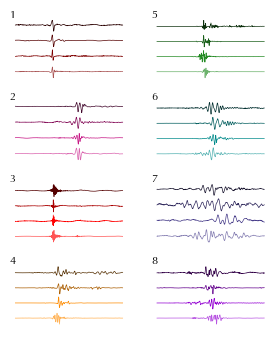

In [51]:
inv = inv.select(station='BBS??')

fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(one_col,one_col*1.2),gridspec_kw={'hspace':0.3})
axes = axes.flatten(order='F')
for ii, group in enumerate(threshold_dict):
    ax = axes[ii]
    ax.set_axis_off()

    ax.annotate(group,(0,1),xycoords='axes fraction')
    #ax.annotate('threshold: ' + str(threshold_dict[group]),(1,0),xycoords='axes fraction',ha='right',va='top')

    left = mcolors.to_rgb('white')
    middle = mcolors.to_rgb(c[ii])
    right = mcolors.to_rgb('black')
    custom_cm = LinearSegmentedColormap.from_list('custom',[left,middle,right])


    sublist = []
    for key in all_templates:
        if key[:-1] == group:
            sublist.append(key)

    templates = {k:all_templates[k] for k in sublist}


    xcorr_mat = np.zeros((len(templates),len(templates)))
    shift_mat = np.zeros((len(templates),len(templates)))

    for i, event_id_1 in enumerate(templates.values()):
        event_1 = event_cat.select_event(event_id_1)
        event_1.attach_waveforms(inv,w_path,buffer=2,length=4,extra=10)
        event_1.filter('highpass',freq=1)

        for j, event_id_2 in enumerate(templates.values()):
            event_2 = event_cat.select_event(event_id_2)
            event_2.attach_waveforms(inv,w_path,buffer=2,length=4,extra=10)
            event_2.filter('highpass',freq=1)

            shift, xc = ec.cross_correlate(event_1,event_2)
            xcorr_mat[i,j] = xc
            shift_mat[i,j] = shift

    i = 0
    for name, template in templates.items():
        frac = (i+2) / (len(templates)+2)

        event = event_cat.select_event(template)
        
        event.attach_waveforms(inv,w_path,buffer=2,length=4,extra=10)
        event.filter('highpass',freq=1)

        max_energy = 0.0
        for tr in event.get_data_window().select(component='Z'):
            energy = np.sum(tr.data**2)
            if energy > max_energy:
                max_energy = energy
                max_tr = tr
        
        net, sta, loc, ch = max_tr.id.split('.')
        max_tr2 = event.stream.select(network=net,station=sta,channel=ch)[0]

        if i > 0:
            shift += shift_mat[i,i-1] / 100
        else:
            shift = 0.0

            
        shift_window = [event.data_window[0] + shift, event.data_window[1] + shift]
        #tr = max_tr.trim(*shift_window,pad=True,fill_value=None)
        tr = max_tr2.trim(*shift_window,pad=True,fill_value=None)

        offset = 10*i

        ax.plot(tr.times(),tr.data/np.abs(tr.data).max()*4 + offset,lw=0.5,color=custom_cm(frac))

        i += 1


fig.savefig(os.path.join(p_path,'Fig6_templates.pdf'),bbox_inches='tight',dpi=400)

## Fig. 7: Backazimith Comparison

/var/folders/z4/gw28hj796zjdxt4nltp_h5g1m6cl00/T/ipykernel_34354/2777717657.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  att_drop['ang_diff'] = att_drop['mfp_baz'] - att_drop['pol_baz']
/var/folders/z4/gw28hj796zjdxt4nltp_h5g1m6cl00/T/ipykernel_34354/2777717657.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  att_drop['ang_diff'] = (att_drop['ang_diff'] + np.pi) % (2*np.pi) - np.pi
/var/folders/z4/gw28hj796zjdxt4nltp_h5g1m6cl00/T/ipykernel_34354/2777717657.py:57: SettingWithCopyWarning: 
A value

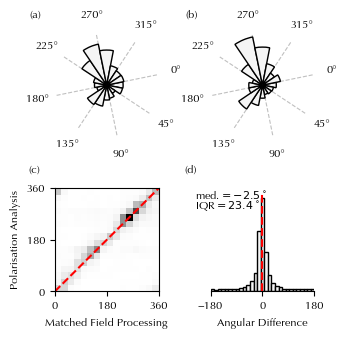

In [52]:
attributes = chunk.load_csv(c_path,'waveform_attributes')
attributes['mfp_baz'] = mfp['baz_opt']
attributes['pol_baz'] = pol['baz_opt']

fig = plt.figure(figsize=(one_col,one_col))
grid_spec = fig.add_gridspec(ncols=2,nrows=2,width_ratios=[1,1],height_ratios=[1,1],hspace=0.5,wspace=0.5)

mfp_rose = fig.add_subplot(grid_spec[0,0],projection='polar')
pol_rose = fig.add_subplot(grid_spec[0,1],projection='polar',sharey=mfp_rose)

mfp_pol = fig.add_subplot(grid_spec[1,0])

baz_bins = np.linspace(0,2*np.pi,num_bins+1)
baz_bins_deg = np.rad2deg(baz_bins)

att_drop = attributes.dropna()

mfp_count, _ = np.histogram(att_drop['mfp_baz'],bins=baz_bins)
pol_count, _ = np.histogram(att_drop['pol_baz'],bins=baz_bins)

mfp_pol_count, _, _ = np.histogram2d(att_drop['mfp_baz'],att_drop['pol_baz'],(baz_bins,baz_bins))


mfp_pol.pcolormesh(baz_bins_deg,baz_bins_deg,mfp_pol_count.T,cmap='binary')
mfp_pol.plot(baz_bins_deg,baz_bins_deg,ls='--',color='red')

mfp_pol.set_xlabel('Matched Field Processing')
mfp_pol.set_ylabel('Polarisation Analysis')

mfp_pol.set_xticks([0,180,360])
mfp_pol.set_yticks([0,180,360])

for rose_ax in [mfp_rose,pol_rose]:
    station_lon = 78.439034
    rose_ax.set_theta_zero_location('N',offset=-station_lon)
    rose_ax.set_theta_direction(-1)
    rose_ax.set_yticks([])
    rose_ax.spines['polar'].set_visible(False)
    rose_ax.xaxis.grid(linestyle='--',color='silver')

mfp_rose.bar(baz_bins[:-1],height=mfp_count,width=np.diff(baz_bins),align='edge',facecolor='whitesmoke',edgecolor='black')#color='dimgrey')
mfp_rose.set_axisbelow(True)
pol_rose.bar(baz_bins[:-1],height=pol_count,width=np.diff(baz_bins),align='edge',facecolor='whitesmoke',edgecolor='black')
pol_rose.set_axisbelow(True)


#mfp_rose.set_title('MFP', rotation='vertical',x=-0.1,y=0.5)
#mfp_rose.set_title('MFP Backazimuth',fontsize=8)
#pol_rose.set_title('Polarisation Backazimuth',fontsize=8)
#mfp_rose.annotate('MFP',(-0.1,1.1),xycoords='axes fraction')

#pol_rose.set_title('Polarisation')
#mfp_rose.set_title('MFP')

att_drop['ang_diff'] = att_drop['mfp_baz'] - att_drop['pol_baz']
att_drop['ang_diff'] = (att_drop['ang_diff'] + np.pi) % (2*np.pi) - np.pi
att_drop['ang_diff_deg'] = np.rad2deg(att_drop['ang_diff'])

diff_bins = np.linspace(-180,180,30)
hist,_ = np.histogram(att_drop['ang_diff_deg'],bins=diff_bins)

diff_ax = fig.add_subplot(grid_spec[1,1])
diff_ax.bar(diff_bins[:-1],hist,width=np.diff(diff_bins),align='edge',facecolor='whitesmoke',edgecolor='black')#color='dimgrey')

diff_ax.spines['top'].set_visible(False)
diff_ax.spines['left'].set_visible(False)
diff_ax.spines['right'].set_visible(False)

diff_ax.set_yticks([])
diff_ax.set_xticks([-180,0,180])
diff_ax.set_xlim((-180,180))
diff_ax.vlines(0,ymin=0,ymax=diff_ax.get_ylim()[1],ls='--',color='red')
diff_ax.set_xlabel('Angular Difference')

st_dev = att_drop['ang_diff_deg'].std()
mean = att_drop['ang_diff_deg'].mean()
q25, med, q75 = att_drop['ang_diff_deg'].quantile([0.25,0.5,0.75])
iqr = q75 - q25

diff_ax.annotate(r'med.$ = {:.1f}^\circ$'.format(med),xy=(-0.15,0.9),xycoords='axes fraction')
diff_ax.annotate(r'IQR$ = {:.1f}^\circ$'.format(iqr),xy=(-0.15,0.8),xycoords='axes fraction')

mfp_rose.annotate('(a)',(-0.25,1.15),xycoords='axes fraction')
pol_rose.annotate('(b)',(-0.25,1.15),xycoords='axes fraction')
mfp_pol.annotate('(c)',(-0.25,1.15),xycoords='axes fraction')
diff_ax.annotate('(d)',(-0.25,1.15),xycoords='axes fraction')

fig.savefig(os.path.join(p_path,'Fig7_backazimuth_comparison.pdf'),bbox_inches='tight',dpi=400)

## Fig. 8: Spatio-Temporal Distribution

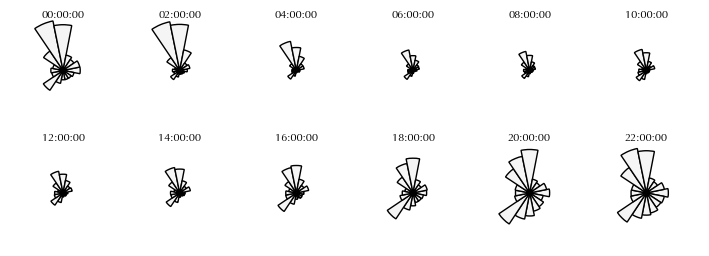

In [53]:
day_start = UTCDateTime(2018,1,1)
day_end = UTCDateTime(2018,1,2)

for event_id, row in attributes.iterrows():
    time = UTCDateTime(event_cat.events.at[event_id,'ref_time'])
    attributes.at[event_id,'time'] = time.matplotlib_date
    attributes.at[event_id,'diurnal'] = UTCDateTime(2018,1,1,time.hour,time.minute,time.second).matplotlib_date

    dt = time - tide.stats.starttime
    attributes.at[event_id,'tidal'] = np.interp(dt,phase.times(),phase.data)

fig, axes = plt.subplots(figsize=(two_col,0.35*two_col),ncols=6,nrows=2,sharey=True,subplot_kw={'projection': 'polar'},layout='constrained')
axes = axes.flatten()
time_bins = np.mgrid[day_start:day_end+1:2*60*60]
time_bins_mt = [time.matplotlib_date for time in time_bins]
hist,_,_ = np.histogram2d(attributes['diurnal'],attributes['pol_baz'],bins=(time_bins_mt,baz_bins))

for i in range(12):
    hist_slice = hist[i,:]
    rose_ax = axes[i]

    rose_ax.set_theta_zero_location('N',offset=-centre[1])
    rose_ax.set_theta_direction(-1)
    rose_ax.set_xticks([])
    rose_ax.set_yticks([])
    rose_ax.spines['polar'].set_visible(False)

    rose_ax.bar(baz_bins[:-1],hist_slice,width=np.diff(baz_bins),align='edge',facecolor='whitesmoke',edgecolor='black')
    rose_ax.annotate(time_bins[i].strftime('%H:%M:%S'),(0.5,1),xycoords='axes fraction',ha='center')

fig.savefig(os.path.join(p_path,'Fig8_spatio_temp_dist.pdf'),bbox_inches='tight',dpi=400)

## Fig. 9: Trigger and Template Catalogues

In [54]:
temp_cat = do.EventCatalogue(t1,t2,c_path,templates=True)

for event_id, row in temp_cat.attributes.iterrows():
    time = UTCDateTime(temp_cat.events.at[event_id,'ref_time'])
    temp_cat.attributes.at[event_id,'time'] = time.matplotlib_date
    temp_cat.attributes.at[event_id,'diurnal'] = UTCDateTime(2018,1,1,time.hour,time.minute,time.second).matplotlib_date

    dt = time - tide.stats.starttime
    temp_cat.attributes.at[event_id,'tidal'] = np.interp(dt,phase.times(),phase.data)
    temp_cat.attributes.at[event_id,'group_num'] = row['group'][0]

/Users/jmagyar/Library/Mobile Documents/com~apple~CloudDocs/Code/Icequakes_remote/iqvis/data_objects.py:663: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  event_cat = pd.concat(events,ignore_index=True)
/Users/jmagyar/Library/Mobile Documents/com~apple~CloudDocs/Code/Icequakes_remote/iqvis/data_objects.py:674: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trace_cat = pd.concat(traces,ignore_index=True)
/Users/jmagyar/Library/Mobile Documents/com~apple~CloudDocs/Code/Icequakes_remote/iqvis/data_o

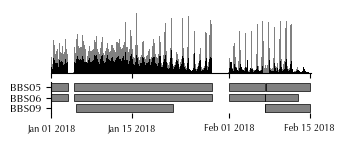

In [55]:
temp_att = temp_cat.attributes

fine_bins = np.array([time.matplotlib_date for time in np.mgrid[chunk.starttime:chunk.endtime+1:2*60*60]])
stalta_hist, _ = np.histogram(attributes['time'],bins=fine_bins)
temp_hist, _ = np.histogram(temp_att['time'],bins=fine_bins)

fig = plt.figure(figsize=(one_col,0.4*one_col))
gs = fig.add_gridspec(nrows=2,height_ratios=[2,1])
ax = fig.add_subplot(gs[0])

ax.bar(fine_bins[:-1],stalta_hist,width=np.diff(fine_bins),color='grey')
ax.bar(fine_bins[:-1],temp_hist,width=np.diff(fine_bins),color='black')

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([])
plt.setp(ax.get_xticklabels(), visible=False)

avail = pd.read_csv('stream_availability.csv')
avail_ax = fig.add_subplot(gs[1],sharex=ax)

i = 0
labels = []
coords = []
for net in inv.select(station='BBS??',channel='??Z'):
    for sta in net:
        for ch in sta:
            subset = df[df['Station']==sta.code]
            start = np.array([UTCDateTime(time).matplotlib_date for time in subset['Start']])#pd.to_datetime(subset['Start'])# + pd.Timedelta(hours=chunk.time_offset)
            end = np.array([UTCDateTime(time).matplotlib_date for time in subset['End']])#pd.to_datetime(subset['End']) #+ pd.Timedelta(hours=chunk.time_offset)
            duration = end - start

            
            avail_ax.barh(i,duration,height=0.7,left=start,fc='grey',ec='black',lw=0.5)
            coords.append(i)
            labels.append(sta.code)

            i -= 1

avail_ax.set_yticks(coords)
avail_ax.set_yticklabels(labels)
avail_ax.spines['right'].set_visible(False)
#avail_ax.spines['left'].set_visible(False)
avail_ax.spines['top'].set_visible(False)
avail_ax.spines['bottom'].set_visible(False)

avail_ax.set_ylim(-2.5,0.5)

avail_ax.set_xlim((fine_bins[0],fine_bins[-1]+0.2))
_set_xaxis_obspy_dates(avail_ax)

fig.savefig(os.path.join(p_path,'Fig9_template_trigger_comp_narrow.pdf'),bbox_inches='tight',dpi=400)

## Fig. 10: Temporal Distribution

In [56]:
temp_groups = temp_cat.group_split()

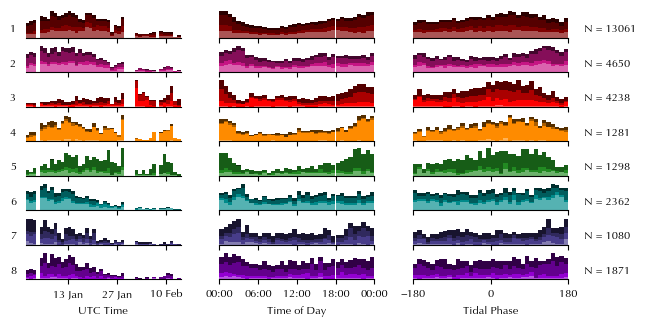

In [57]:
"""BINNING PARAMETERS"""
daily_bins = 40*60 
total_bins = 24*60*60 
tide_bins = 10 #width in degrees of bins


"""BIN CONSTRUCTION"""
total_bin_edges = np.mgrid[t1:t2:total_bins]
total_bin_edges_mt = np.array([time.matplotlib_date for time in total_bin_edges])

day_start = UTCDateTime(2018,1,1)
day_end = UTCDateTime(2018,1,2)

daily_bin_edges = np.mgrid[day_start:day_end+1:daily_bins]
daily_bin_edges_mt = np.array([time.matplotlib_date for time in daily_bin_edges])

tide_bin_edges = np.mgrid[-180:181:tide_bins]


fig = plt.figure(figsize=(two_col,0.5*two_col))
gs = fig.add_gridspec(ncols=3,nrows=8,height_ratios=[1,1,1,1,1,1,1,1],width_ratios=[1,1,1],wspace=0.25,hspace=0.25)


bins = {'time':total_bin_edges_mt,
        'diurnal':daily_bin_edges_mt,
        'tidal':tide_bin_edges,
        'mfp_baz':baz_bins,
        'pol_baz':baz_bins}

labels = {'time':'UTC Time',
        'diurnal':'Time of Day',
        'tidal':'Tidal Phase',
        'amplitude':'Amplitude (m/s)',
        'mean_freq':'Frequency (Hz)',
        'duration':'Duration (s)',
        'mfp_baz':'MFP \n Backazimuth',
        'pol_baz':'Polarisation \n Backazimuth'}

for l, x_axis in enumerate(['time','diurnal','tidal']):

    for ii, group in enumerate(threshold_dict):
        current_ax = fig.add_subplot(gs[ii,l])

        sublist = []
        for key in all_templates:
            if key[:-1] == group:
                sublist.append(key)
        templates = {k:all_templates[k] for k in sublist}

        left = mcolors.to_rgb('white')
        middle = mcolors.to_rgb(c[ii])
        right = mcolors.to_rgb('black')

        custom_cm = LinearSegmentedColormap.from_list('custom',[left,middle,right])

        cumulative = np.zeros_like(bins[x_axis][:-1])

        for i, temp_name in enumerate(templates):
                    
            frac = (i+2) / (len(templates)+2)

            group_att = temp_att[temp_att['group']==temp_name]

            hist, _ = np.histogram(group_att[x_axis],bins=bins[x_axis])

            current_ax.bar(bins[x_axis][:-1],hist,width=np.diff(bins[x_axis]),bottom=cumulative,align='edge',color=custom_cm(frac))

            cumulative += hist

        if x_axis == 'diurnal':
            current_ax.set_xlim(daily_bin_edges_mt[0],daily_bin_edges_mt[-1])
            myFmt = DateFormatter("%H:%M")
            current_ax.xaxis.set_major_formatter(myFmt)
            current_ax.xaxis.set_major_locator(HourLocator(interval=6))

        if x_axis == 'time':
            current_ax.set_xlim(total_bin_edges_mt[0],total_bin_edges_mt[-1])
            myFmt = DateFormatter("%d %b")
            current_ax.xaxis.set_major_formatter(myFmt)
            current_ax.xaxis.set_major_locator(DayLocator(interval=14))
            current_ax.annotate(group,(-0.1,0.2),xycoords='axes fraction')

            #_set_xaxis_obspy_dates(current_ax)
        
        if x_axis == 'tidal':
            current_ax.set_xlim((-180,180))
            current_ax.set_xticks([-180,0,180])
            current_ax.annotate('N = ' + str(np.sum(cumulative)),(1.1,0.2),xycoords='axes fraction')

        if ii != 7:
            plt.setp(current_ax.get_xticklabels(), visible=False)
        else:
            current_ax.set_xlabel(labels[x_axis])

        current_ax.spines['top'].set_visible(False)
        current_ax.spines['left'].set_visible(False)
        current_ax.spines['right'].set_visible(False)
        current_ax.set_yticks([])


fig.savefig(os.path.join(p_path,'Fig10_temporal_groups.pdf'),bbox_inches='tight',dpi=400)

## Fig. 11: Spatial Clusters

In [58]:
temp_pol = chunk.load_csv(c_path,'template_polarisation_localisation_opt')
temp_wave_att = chunk.load_csv(c_path,'template_waveform_attributes')

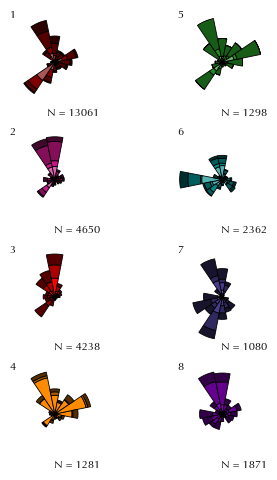

In [59]:
temp_att['pol_baz'] = temp_pol['baz_opt']

fig, axes = plt.subplots(figsize=(one_col,1.4*one_col),ncols=2,nrows=4,sharey=False,subplot_kw={'projection': 'polar'},layout='constrained')
axes = axes.flatten(order='F')

for ii, group in enumerate(threshold_dict):
    ax = axes[ii]
    ax.set_axis_off()

    ax.annotate(group,(0,1),xycoords='axes fraction')
    
    ax.set_theta_zero_location('N',offset=-station_lon)
    ax.set_theta_direction(-1)

    sublist = []
    for key in all_templates:
        if key[:-1] == group:
            sublist.append(key)
    templates = {k:all_templates[k] for k in sublist}

    left = mcolors.to_rgb('white')
    middle = mcolors.to_rgb(c[ii])
    right = mcolors.to_rgb('black')

    custom_cm = LinearSegmentedColormap.from_list('custom',[left,middle,right])

    cumulative = np.zeros(num_bins,np.int16)

    for i, temp_name in enumerate(templates):
                
        frac = (i+2) / (len(templates)+2)

        group_pol = temp_att[temp_att['group']==temp_name]

        baz_hist, _ = np.histogram(group_pol['pol_baz'],bins=baz_edges)

        ax.bar(baz_edges[:-1],baz_hist,width=np.diff(baz_edges),bottom=cumulative,align='edge',facecolor=custom_cm(frac),edgecolor='black',linewidth=0.6)

        cumulative += baz_hist
    
    ax.annotate('N = ' + str(np.sum(cumulative)),(1,0),xycoords='axes fraction',ha='right',va='top')


fig.savefig(os.path.join(p_path,'Fig11_group_baz_narrow.pdf'),bbox_inches='tight',dpi=400)

## Table 1: Template Matching

In [60]:
manual_cat = do.EventCatalogue(t1,t2,c_path)
manual_cat.add_classification(pd.read_csv(os.path.join(c_path,'classified_catalogue.csv'),index_col=0))
manual_group_cats = manual_cat.group_split()

temp_att['amplitude'] = temp_wave_att['amplitude']
temp_att['mean_freq'] = temp_wave_att['mean_freq']
temp_att['duration'] = temp_wave_att['duration']

table = pd.DataFrame(columns=[key for key in threshold_dict.keys()])

for key, thresh in threshold_dict.items():
    table.at['Threshold',key] = thresh
    table.at['Manual N',key] = manual_group_cats[int(key)].N
    table.at['Auto N',key] = len(temp_att[temp_att['group_num']==key])

    table.at['Manual Amplitude',key] = attributes[attributes.index.isin(manual_group_cats[int(key)].events.index)]['amplitude'].median() * 1e6
    table.at['Auto Amplitude',key] = temp_att[temp_att['group_num']==key]['amplitude'].median() * 1e6

    table.at['Manual Frequency',key] = attributes[attributes.index.isin(manual_group_cats[int(key)].events.index)]['mean_freq'].median()
    table.at['Auto Frequency',key] = temp_att[temp_att['group_num']==key]['mean_freq'].median()

    table.at['Manual Duration',key] = attributes[attributes.index.isin(manual_group_cats[int(key)].events.index)]['duration'].median()
    table.at['Auto Duration',key] = temp_att[temp_att['group_num']==key]['duration'].median()


table

/Users/jmagyar/Library/Mobile Documents/com~apple~CloudDocs/Code/Icequakes_remote/iqvis/data_objects.py:663: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  event_cat = pd.concat(events,ignore_index=True)
/Users/jmagyar/Library/Mobile Documents/com~apple~CloudDocs/Code/Icequakes_remote/iqvis/data_objects.py:674: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trace_cat = pd.concat(traces,ignore_index=True)


,1,2,3,4,5,6,7,8
Threshold,0.8,0.75,0.65,0.75,0.75,0.75,0.65,0.65
Manual N,183,129,41,81,66,69,116,75
Auto N,13061,4650,4238,1281,1298,2362,1080,1871
Manual Amplitude,3.403603,6.529157,2.398598,9.052154,46.293875,7.226846,6.915309,10.839637
Auto Amplitude,3.200176,3.461534,4.037234,5.816722,4.143763,3.949047,5.57906,4.875474
Manual Frequency,6.639579,5.295835,23.22556,7.553115,13.005563,4.623093,3.554144,6.45797
Auto Frequency,6.340741,5.433294,19.727293,7.715141,9.350577,4.664871,3.601821,5.424774
Manual Duration,1.771989,3.431989,1.021988,4.871989,12.226988,3.481989,5.106988,6.211988
Auto Duration,2.661988,5.761988,1.051989,14.651988,7.461988,5.931988,2.571988,7.541989


In [61]:
np.sum(table.T['Auto N'])

29841